# Prior estimation with the Empirical Reference Prior
## Comparison of the ERP to the empirical Prior with Thikonov regularization
applied to a simple model with crossvalidation optimization of the regularization parameter

In [ ]:
using Revise
using ObjectiveEmpiricalBayes, Distributions
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot
using Random: seed!

linspace(x...) = LinRange(x...) |> collect
midpoints(min, max, n) = [min + (max-min) / n * (i-1/2) for i=1:n]

In [2]:
# hotfix for error in rand truncated mixturemodel
# c.f. https://github.com/JuliaStats/Distributions.jl/issues/1102

import Distributions.rand
function rand(d::Truncated{MixtureModel{Univariate,Continuous,Normal{Float64},Float64},Continuous,Float64}, n::Int64)
    xs = zeros(n)
    i = 1
    while i < n+1
        x = rand(d.untruncated)
        if x > d.lower && x < d.upper
            xs[i] = x
            i+=1
        end
    end
    xs
end

rand (generic function with 183 methods)

## The Model
The model consists of the identity function f:x->x and a Normal measurement error.
For the synthetic data we specify a Mixture of Normals as true prior.

We also consider a copy of the model on a exp-transformed state-space.

In [3]:


xlims = (0,4)
n = 200
xs = midpoints(xlims..., n)

ndata = 100
σ = 0.3
prior = truncated(MixtureModel([Normal(mu, .5) for mu in [1, 3]]), xlims...)

t    = Transformation(x->exp(x), x->log(x))

randseed=90
seed!(randseed)
#srand(2)
m = FEModel(f=x->x, xs=xs, σ=σ)
d = generatedata(m, prior, ndata);

mt   = transformmodel(m, t)

FEModel(ObjectiveEmpiricalBayes.var"#ft#74"{FEModel,Transformation}(FEModel(var"#11#12"(), [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19  …  3.81, 3.83, 3.85, 3.87, 3.89, 3.91, 3.93, 3.95, 3.97, 3.99], 0.3), Transformation(var"#7#9"(), var"#8#10"())), range(1.010050167084168, stop=54.0548893633266, length=200), 0.3)

# Computation of the ERP
Compute the optimal regularization parameter gamma as well as the corresponding empirical reference prior for both, the original and transformed model.

In [4]:
# options for the erp optimization
OPTCONFIG=OptConfig(XTOLABS=1e-8);

# options for the cv optimization
gmin = 0
gmax = 1
trace = false
maxiters = 1000
rel_tol = 1e-3;

In [5]:
@time gammaR, _ = ObjectiveEmpiricalBayes.cvreference(m, d, gmin, gmax; c=OPTCONFIG, show_trace=trace, iterations=maxiters, rel_tol=rel_tol)
@time wR = ebprior(m, d, ReferenceRegularizer(m, gammaR), OPTCONFIG);

 30.263946 seconds (15.03 M allocations: 173.408 GiB, 13.35% gc time)
  0.041030 seconds (110.75 k allocations: 89.462 MiB, 24.68% gc time)


In [6]:
@time gammaRt, _ = ObjectiveEmpiricalBayes.cvreference(mt, d, gmin, gmax; c=OPTCONFIG, show_trace=trace, iterations=maxiters, rel_tol=rel_tol)
@time wRt = ebprior(mt, d, ReferenceRegularizer(mt, gammaRt), OPTCONFIG);

 37.353655 seconds (12.66 M allocations: 226.898 GiB, 14.96% gc time)
  0.020040 seconds (67.05 k allocations: 127.805 MiB, 17.25% gc time)


# Results

In [7]:
using PyPlot
PyPlot.rc("text",usetex=true)
scale = 1.1
figsize=(4,3).*scale
lims = ([0,4],[0,.6],[1,55], [0,.2])

([0, 4], [0.0, 0.6], [1, 55], [0.0, 0.2])

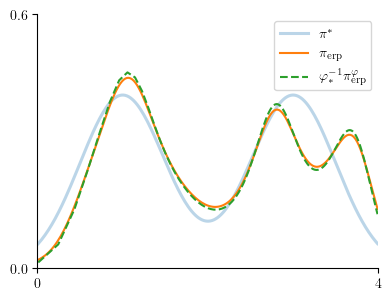

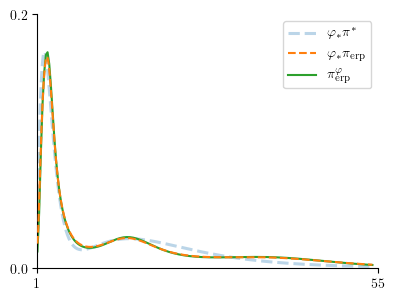

(Figure(PyObject <Figure size 440x330 with 1 Axes>), Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [8]:
p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wR, wRt, "erp", lims...; figsize=figsize, savename="eb$randseed")

# Comparison to the Thikonov Regularizer
We repeat the same steps.
Since a `cvreference` analogue to Thikonov does not exist yet, we do the CV optimization ourselves.
Note that the score is convex in gamma.

We use the resulting gamma for both, the normal and transformed model.

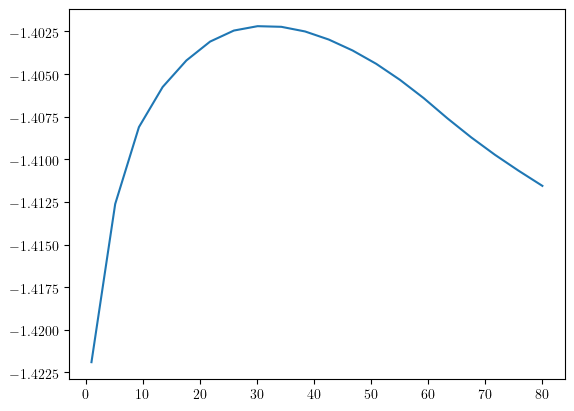

 52.404705 seconds (133.81 M allocations: 321.424 GiB, 15.87% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51c529c110>

In [9]:
ncv = 20 # number of samples for gamma

## thik estimator
regs = [ThikonovRegularizer(γ) for γ in linspace(1,80,ncv)]
@time ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG)) for r in regs]
regT = regs[argmax(ss)].γ
plot([r.γ for r in regs], ss)

In [10]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTto = ebprior(mt, d, ThikonovRegularizer(regT), OPTCONFIG);

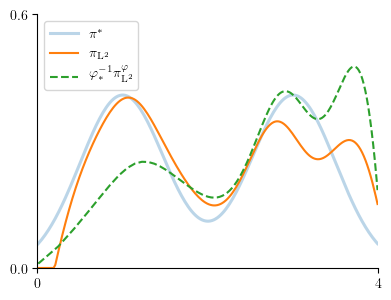

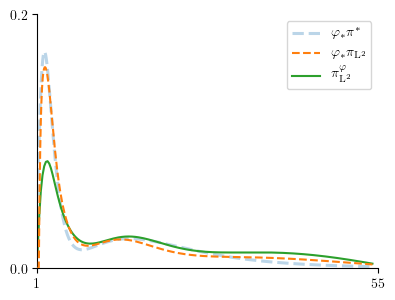

(Figure(PyObject <Figure size 440x330 with 1 Axes>), Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [11]:
p1,p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTto, "L^2", lims...; figsize=figsize, savename="l2$randseed")

# Comparison of the different Priors

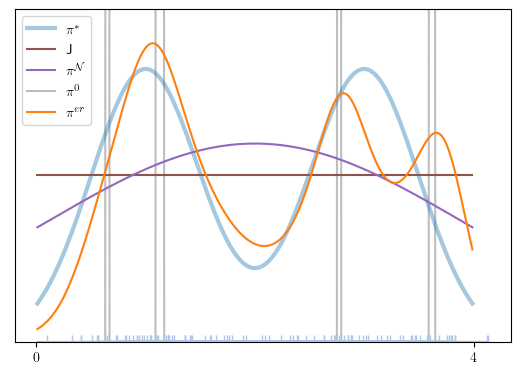

In [12]:
using LinearAlgebra
using PyPlot

w0 = ebprior(m, d, ThikonovRegularizer(0), OptConfig(XTOLABS=1e-30, DEBUG=false);)
w0 = normalize!([(w>0.05) ? 0.001 : 0 for w in w0], 1)
wu = normalize!(ones(length(w0)), 1)

wp = normalize!(pdf.(prior, m.xs), 1)
wn = normalize!(pdf.(Distributions.Normal(2,1.9
            ), m.xs), 1)



w2dens(x) = ObjectiveEmpiricalBayes.weighttodensity(m.xs, x)
scaling = 0.8
PyPlot.figure(figsize=(8*scaling,5.4*scaling))
PyPlot.plot(m.xs, wp|>w2dens, label="\$\\pi^*\$", alpha=.4, linewidth=3)
PyPlot.plot(m.xs,  wu |> w2dens, label = "J", color="#8c564b")
PyPlot.plot(m.xs, wn|> w2dens, label="\$\\pi^\\mathcal{N}\$", color="#9467bd")
PyPlot.plot(m.xs, w0|> w2dens, label="\$\\pi^0\$", zorder=-100, alpha=.5, color="#7f7f7f")
PyPlot.plot(m.xs, wR|> w2dens, label="\$\\pi^{er}\$")
PyPlot.legend()


PyPlot.plot(d, zero(d), marker="2", markersize=10, color="#aec7e8")
PyPlot.ylim(0,0.5)
PyPlot.xticks([0,4])
PyPlot.yticks([])
PyPlot.savefig("all.pdf", bbox_inches="tight")

# Dependence of the regularization parameter on the transformation
Unlike in the reparametrization-invariant ERP case, for the Thikonov Regularizer the CV optimization returns different optimal gammas for the original and transformed models, as seen below.

 39

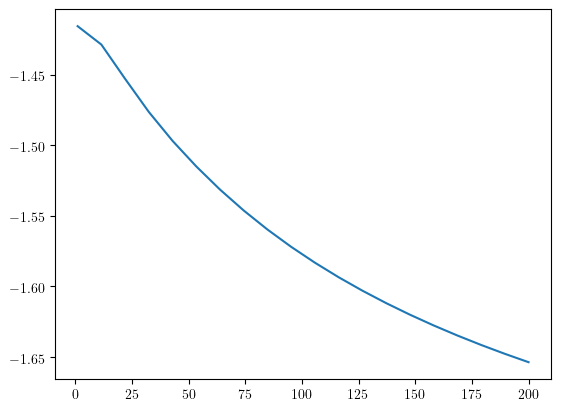

.433783 seconds (130.56 M allocations: 228.329 GiB, 17.63% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51c50c5610>

In [13]:
## thik estimator transformed
regs = [ThikonovRegularizer(γ) for γ in linspace(1,200,ncv)]
@time ss = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG)) for r in regs]
regTt = regs[argmax(ss)].γ
plot([r.γ for r in regs], ss)

In [14]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTt = ebprior(mt, d, ThikonovRegularizer(regTt), OPTCONFIG);

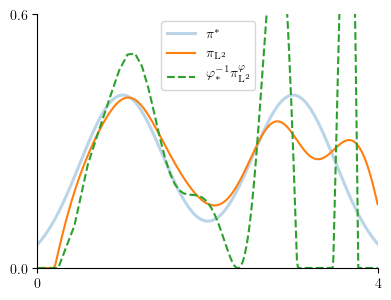

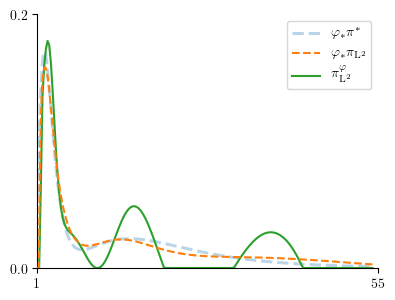

(Figure(PyObject <Figure size 440x330 with 1 Axes>), Figure(PyObject <Figure size 440x330 with 1 Axes>))

In [15]:
p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTt, "L^2", lims...; figsize=figsize, savename="l2$randseed")